Import: modules, functions, classes, variables

In [1]:
import datetime  # Нужно ли в этой тетрадке ?

import numpy as np
import pandas as pd
import seaborn as sns
import pymannkendall as mk
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sys import path
from os import getcwd
from math import isinf
from pickle import dump
from scipy.stats import shapiro
from warnings import simplefilter
from plotly.offline import init_notebook_mode
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

from statsmodels.graphics.tsaplots import plot_acf as autocorr_plot

Set project settings

In [2]:
%matplotlib inline
init_notebook_mode(connected=True)
simplefilter(action="ignore", category=Warning)

Include handwritten modules

In [3]:
modules_path = "../../../src/"

In [4]:
path.append(modules_path)

In [5]:
from auxiliary import *
from feature_engineering import *

Load processed dataframe

In [6]:
processed_df = pd.read_parquet(processed_data_path + getcwd().split("\\")[-1] + processed_data_name)

In [7]:
real_data = processed_df["2024-08":]

In [8]:
processed_df = processed_df[: "2024-07"]

In [9]:
processed_df.head(7)

,peak_hour
days,
2012-04-02,20
2012-04-03,20
2012-04-04,10
2012-04-05,20
2012-04-06,20
2012-04-09,11
2012-04-10,20


In [10]:
processed_df.tail(7)

,peak_hour
days,
2024-07-23,12
2024-07-24,14
2024-07-25,14
2024-07-26,14
2024-07-29,15
2024-07-30,12
2024-07-31,12


Time series time step is a day

Time series has a day gaps

In [11]:
print("Counter of weekend days =", sum((processed_df.index.dayofweek + 1) > 5))

Counter of weekend days = 12


The gaps are weekends

In [12]:
processed_df[(processed_df.index.dayofweek + 1) > 5]

,peak_hour
days,
2012-04-28,21
2012-05-05,11
2012-05-12,9
2012-06-09,10
2012-12-29,9
2016-02-20,8
2018-04-28,20
2018-06-09,9
2018-12-29,16


Available days off are working days

In [13]:
print("Processed dataframe has a", sum(create_holiday_feature(processed_df)), "holidays")

Processed dataframe has a 0 holidays


Processed dataframe hasn't a holidays

In [14]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3033 entries, 2012-04-02 to 2024-07-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   peak_hour  3033 non-null   int64
dtypes: int64(1)
memory usage: 47.4 KB


1) The first date is `2012-04-02`
2) The last date is `2024-07-31`

In [15]:
print("The full processed dataframe should contain", (processed_df.index[-1] - processed_df.index[0]).days, "days")

The full processed dataframe should contain 4503 days


Processed dataframe has a 3033 days

In [16]:
print("Our processed dataframe doesn't have a", round(1 - 3033 / 4503, 2), "% of the full time series")

Our processed dataframe doesn't have a 0.33 % of the full time series


In [17]:
processed_df.describe()

,peak_hour
count,3033.000000
mean,14.458292
std,4.111931
min,8.000000
25%,11.000000
50%,14.000000
75%,18.000000
max,21.000000


1) The typical target value is 18
2) Standart deviation of the target is 20 % of the target mean 
3) The target interquartile range is 5, the target variability is high
4) The minium target value is smaller in 2.1 times than the maximum target value
5) Many unique target values are in the first quartile, we have a lot of rare target values

In [18]:
print("Processed dataframe has next years:", ", ".join([str(year) for year in processed_df.index.year.unique()]))

Processed dataframe has next years: 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024


Processed dataframe starts from 2012 to 2024 year

In [19]:
[print("Year", str(time_components[0]) + ":\n     Included month numbers:", *time_components[1], "\n") for
 time_components in
 zip(processed_df.index.year.unique(), [months for months in
                                        [processed_df[processed_df.index.year == year].index.month.unique() for year in
                                         [year for year in processed_df.index.year.unique()]]])];

Year 2012:
     Included month numbers: 4 5 6 7 8 9 10 11 12 

Year 2013:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2014:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2015:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2016:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2017:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2018:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2019:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2020:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2021:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2022:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2023:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2024:
     Included month numbers: 1 2 3 4 5 6 7 



The border years are incomplete

In [20]:
analyt_processed_df = processed_df.copy()

In [21]:
analyt_processed_df["year"] = analyt_processed_df.index.year
analyt_processed_df["day_of_year"] = analyt_processed_df.index.dayofyear

Processed data visualisation

In [22]:
scatters_plot(analyt_processed_df, "day_of_year", "peak_hour", "year", "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)",
              "Day of year",
              "Peak hour")

Processed dataframe has an emissions

Let's replace them by nearby values

In [23]:
# processed_df[processed_df["peak_hour"] == 10] = 11

In [24]:
# processed_df[(processed_df.index.year == 2019) & (processed_df.index.dayofyear == 197)] = 17

In [25]:
# processed_df[(processed_df.index.year == 2023) & (processed_df.index.dayofyear == 303)] = 18

In [26]:
# processed_df[
#     (processed_df.index.year == 2024) & (processed_df.index.dayofyear <= 31) & (processed_df["peak_hour"] == 11)] = 18

In [27]:
# processed_df[
#     (processed_df.index.year == 2014) & (processed_df.index.dayofyear <= 31) & (processed_df["peak_hour"] == 11)] = 18

In [28]:
analyt_processed_df = processed_df.copy()

Repeat processed data visualisation

In [29]:
analyt_processed_df["year"] = analyt_processed_df.index.year
analyt_processed_df["day_of_year"] = analyt_processed_df.index.dayofyear

In [30]:
scatters_plot(analyt_processed_df, "day_of_year", "peak_hour", "year", "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)",
              "Day of year",
              "Peak hour")

The processed data is noisy and weakly follows the pattern

Let's compare every neighboring years

In [31]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2012) | (analyt_processed_df.index.year == 2013)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [32]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2013) | (analyt_processed_df.index.year == 2014)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [33]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2014) | (analyt_processed_df.index.year == 2015)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [34]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2015) | (analyt_processed_df.index.year == 2016)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [35]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2016) | (analyt_processed_df.index.year == 2017)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [36]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2017) | (analyt_processed_df.index.year == 2018)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [37]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2018) | (analyt_processed_df.index.year == 2019)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [38]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2019) | (analyt_processed_df.index.year == 2020)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [39]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2020) | (analyt_processed_df.index.year == 2021)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [40]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2021) | (analyt_processed_df.index.year == 2022)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [41]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2022) | (analyt_processed_df.index.year == 2023)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [42]:
scatters_plot(analyt_processed_df[(analyt_processed_df.index.year == 2023) | (analyt_processed_df.index.year == 2024)],
              "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In the analysis we will use whole years of the time series.

That means thath we will cut a part of old data, because the new data is more important.

* Target distribution:

In [43]:
# # ?
# def graph_plot(graph_type: str, graph_data: pd.DataFrame, graph_target_name: str, graph_x_label: str,
#                graph_y_label: str, graph_title: str, graph_grid: bool, graph_x_size: int = 10, graph_y_size: int = 10,
#                graph_feature_name: str = None):
#     plt.figure(figsize=(graph_x_size, graph_y_size))

#     if graph_type == "countplot":
#         sns.countplot(x=graph_target_name, data=graph_data)

#     plt.xlabel(graph_x_label)
#     plt.ylabel(graph_y_label)
#     plt.title(graph_title)

#     if graph_grid:

#     ...

In [44]:
# graph_plot("countplot", processed_df, "peak_hour", "Peak hour", "Hour frequency", "Peak Hours (Countplot)", True, 15, 3)

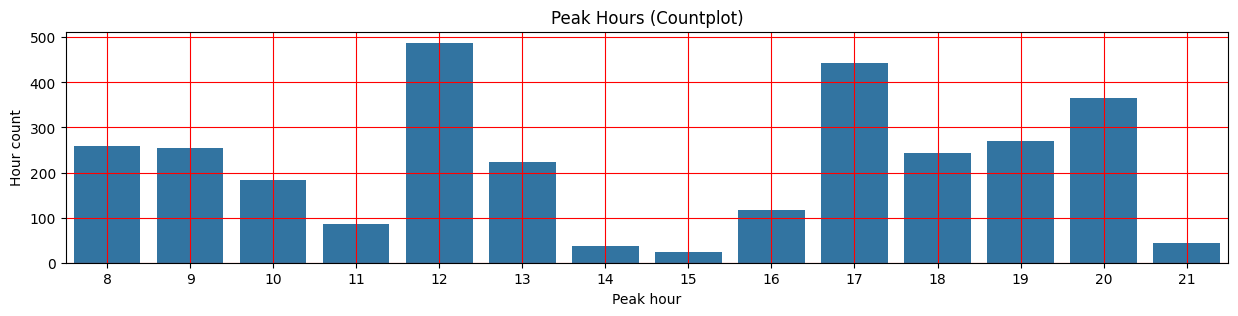

In [45]:
plt.figure(figsize=(15, 3))
sns.countplot(x="peak_hour", data=processed_df)
plt.xlabel("Peak hour")
plt.ylabel("Hour count")
plt.title("Peak Hours (Countplot)")
plt.grid(color='r', linestyle='-');

Does target has a normal distribution?

In [46]:
print("Answer:", str(shapiro(analyt_processed_df["peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

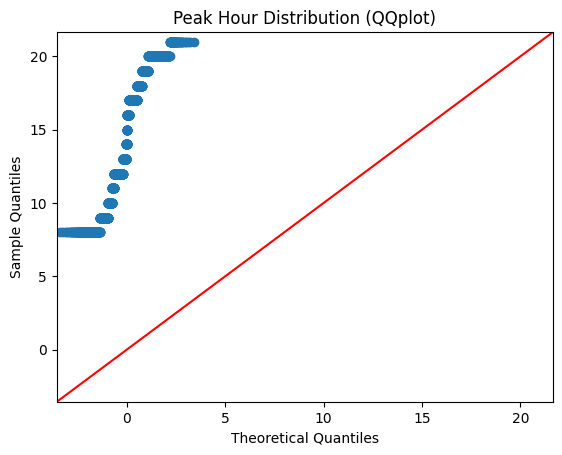

In [47]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_processed_df["peak_hour"], line="45")
plt.title("Peak Hour Distribution (QQplot)");

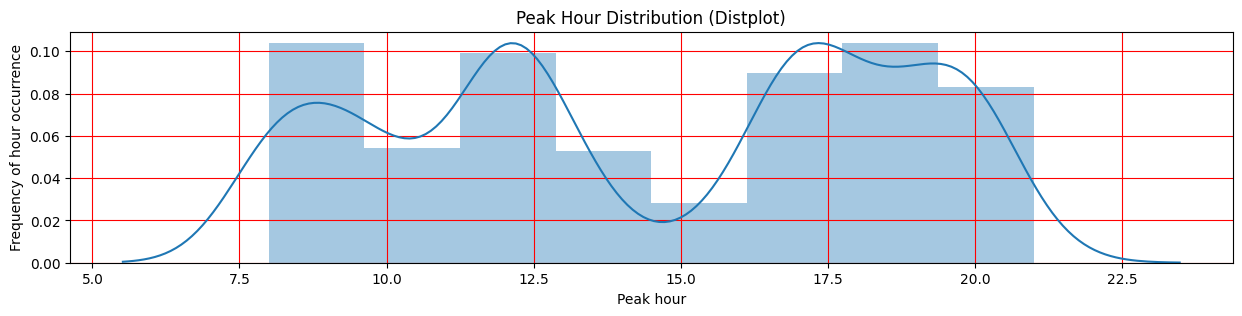

In [48]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_processed_df["peak_hour"], bins=8, hist=True)
plt.xlabel("Peak hour")
plt.ylabel("Frequency of hour occurrence")
plt.title("Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

Obviously, the target distribution is not normal.

________________________________________________________________________________________________________________________________________________________

* Target trend:

In [49]:
analyt_processed_df = processed_df["2012-08":].copy()

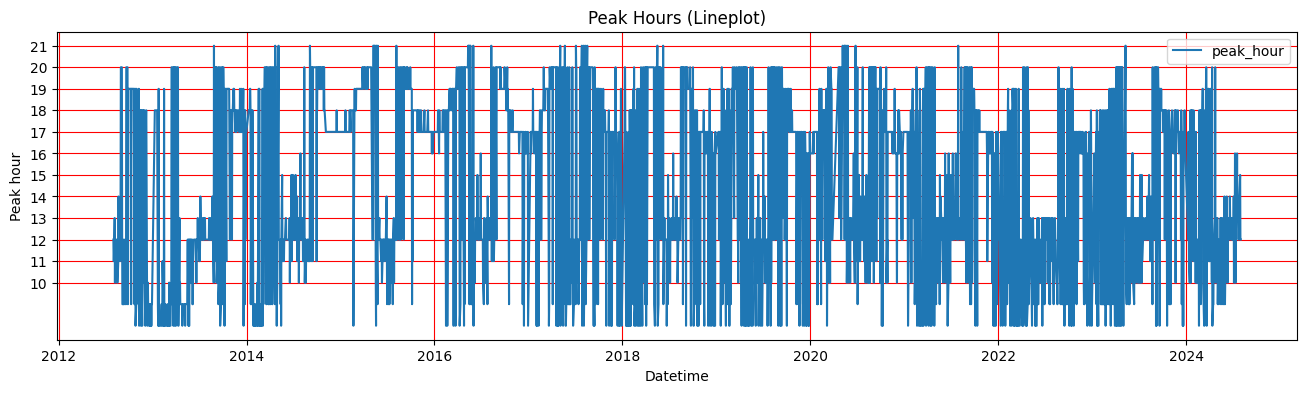

In [50]:
plt.figure(figsize=(16, 4))
figure = sns.lineplot(analyt_processed_df)
figure.set_yticks([_ for _ in range(10, 22)])
plt.xlabel("Datetime")
plt.ylabel("Peak hour")
plt.title("Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does target has a trend?

In [51]:
get_average_months_length(processed_df, 2013, 2023)

22

In [52]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_processed_df, "peak_hour", "mean",
                                  get_average_months_length(analyt_processed_df, 2013, 2023) * 6)
).trend + ".")

Answer: decreasing.


Visualise our suggest:

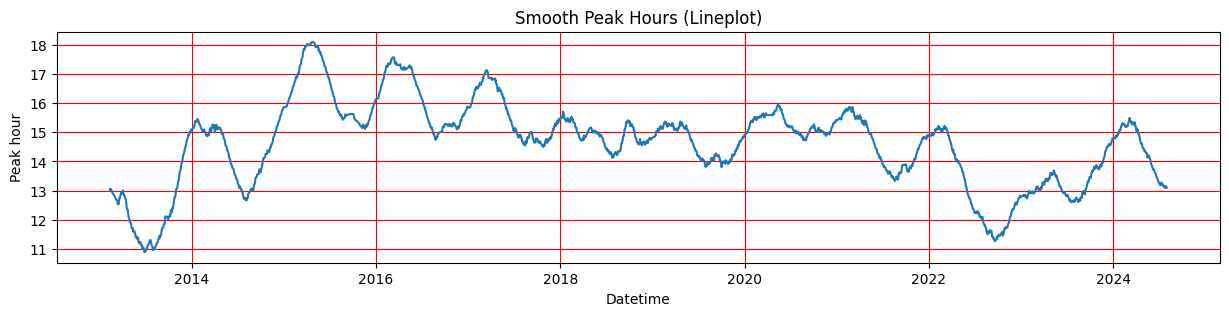

In [53]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    create_rolling_window_feature(analyt_processed_df, "peak_hour", "mean",
                                  get_average_months_length(analyt_processed_df, 2013, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [54]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_processed_df, "peak_hour",
                                                                                 "mean",
                                                                                 get_average_months_length(
                                                                                     analyt_processed_df, 2013, 2023)
                                                                                 * 6)

analyt_processed_df.dropna(inplace=True)

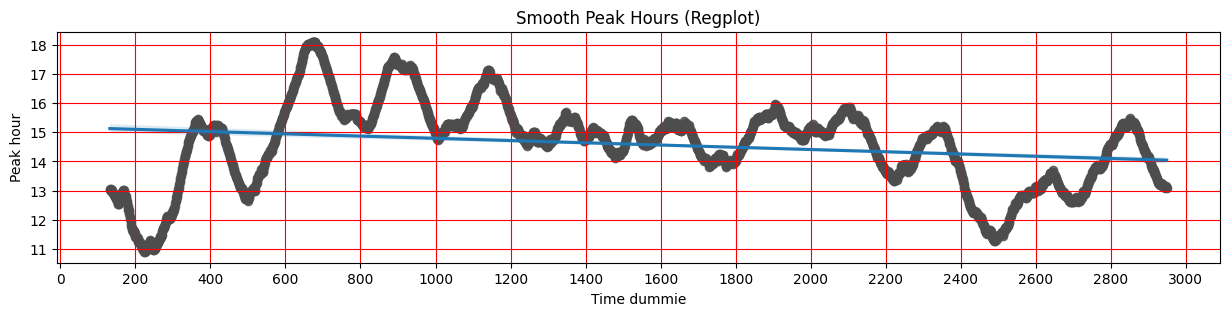

In [55]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(0, 3050, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

We have a fake trend and a big dispersion.

Let's see plot without the first part of the target to be sure that we don't have a generally trend:

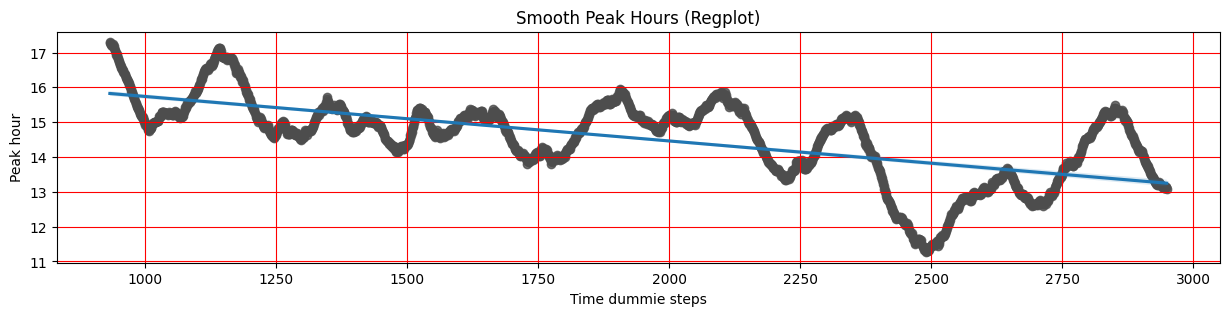

In [56]:
plt.figure(figsize=(15, 3))
sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df.iloc[800:],
            scatter_kws=dict(color="0.30"));
plt.xlabel("Time dummie steps")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

And check the first part of the target to see trend:

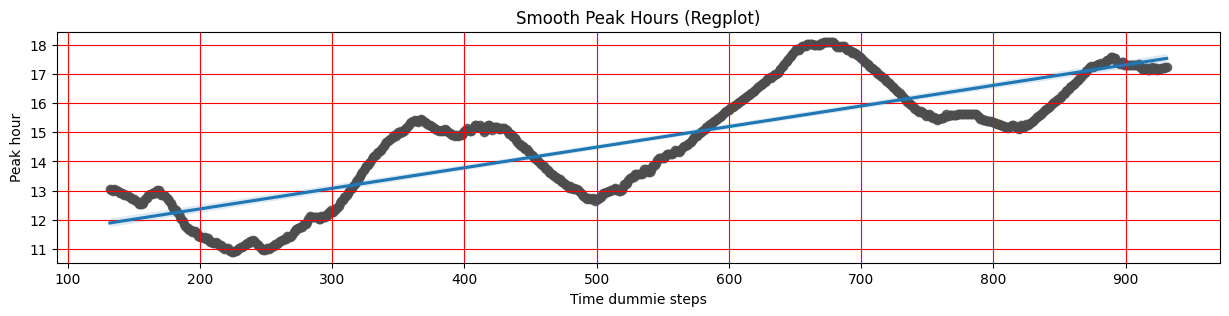

In [57]:
plt.figure(figsize=(15, 3))
sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df.iloc[: 800],
            scatter_kws=dict(color="0.30"));
plt.xlabel("Time dummie steps")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

The trend exists only in part of the data.

It means that we need to normalised target.

_________________________________________________________________________________________________________________________________________________________

* Target normalization:

In [58]:
featured_processed_df = processed_df.copy()

We will use a moved windows for the target normalization and forecasting.

The size of the step - 1 day.

In [59]:
featured_processed_df = normalization(featured_processed_df, "peak_hour")

In [60]:
featured_processed_df.head(2)

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour
days,,,,
2012-04-02,20,NaN,NaN,NaN
2012-04-03,20,NaN,NaN,NaN


In [61]:
featured_processed_df.tail(2)

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour
days,,,,
2024-07-30,12,1.761656,12.269841,-0.153175
2024-07-31,12,1.737953,12.301587,-0.173530


We can have infinity and missing values after normalization in target.

In [62]:
featured_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3033 entries, 2012-04-02 to 2024-07-31
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   peak_hour             3033 non-null   int64  
 1   std_normalization     2970 non-null   float64
 2   mean_normalization    2970 non-null   float64
 3   normalized_peak_hour  2970 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 183.0 KB


In [63]:
featured_processed_df[featured_processed_df["normalized_peak_hour"].isna()].index.values[: 15]

array(['2012-04-02T00:00:00.000000000', '2012-04-03T00:00:00.000000000',
       '2012-04-04T00:00:00.000000000', '2012-04-05T00:00:00.000000000',
       '2012-04-06T00:00:00.000000000', '2012-04-09T00:00:00.000000000',
       '2012-04-10T00:00:00.000000000', '2012-04-11T00:00:00.000000000',
       '2012-04-12T00:00:00.000000000', '2012-04-13T00:00:00.000000000',
       '2012-04-16T00:00:00.000000000', '2012-04-17T00:00:00.000000000',
       '2012-04-18T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2012-04-20T00:00:00.000000000'], dtype='datetime64[ns]')

As we can see we have missing target only at the beginning of data.

This is because we use moving average window, it's ok.

How many infinity values do we have in the data?

In [64]:
print("Answer:", str(sum(featured_processed_df["normalized_peak_hour"].apply(isinf))) + '.')

Answer: 0.


The last one, let's check up our normalized target:

In [65]:
featured_processed_df["time_dummie"] = create_time_dummie_feature(featured_processed_df)

In [66]:
featured_processed_df["mean"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "mean", 22)

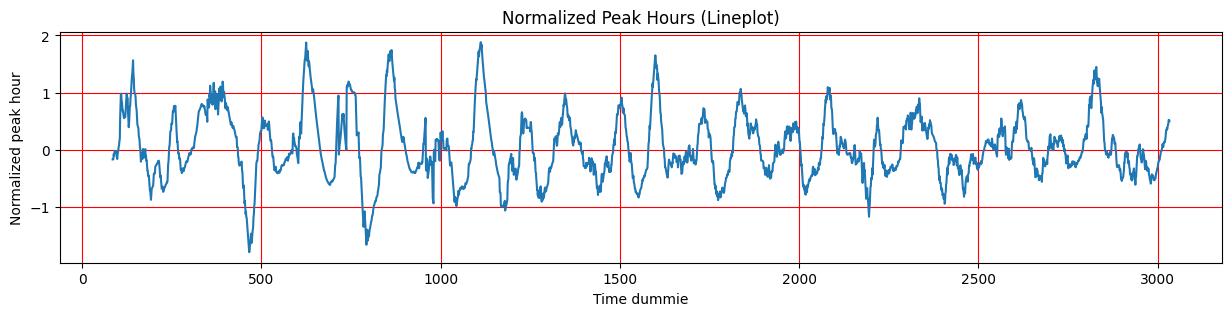

In [67]:
plt.figure(figsize=(15, 3))
sns.lineplot(data=featured_processed_df, x="time_dummie", y="mean")
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

In [68]:
featured_processed_df["normalized_peak_hour"].describe()

count    2970.000000
mean        0.038179
std         1.325845
min       -23.218193
25%        -0.722826
50%         0.041123
75%         0.863482
max         9.244614
Name: normalized_peak_hour, dtype: float64

1) We have the significant deviation of the target - 2023 % of the average value
2) Many target values are in the first quartile
3) Few target values are in the third quartile
4) The minium target value is smaller in 4.35 times than the maximum target valu

processed_df doesn't have missing and infinity target values, but it has outliers.

________________________________________________________________________________________________________________________________________________________

* Normalized target distribution:

In [69]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"]["2012-08":].copy().dropna().to_frame()

Does the normalized target has a normal distribution?

In [70]:
print("Answer:", str(shapiro(analyt_processed_df["normalized_peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

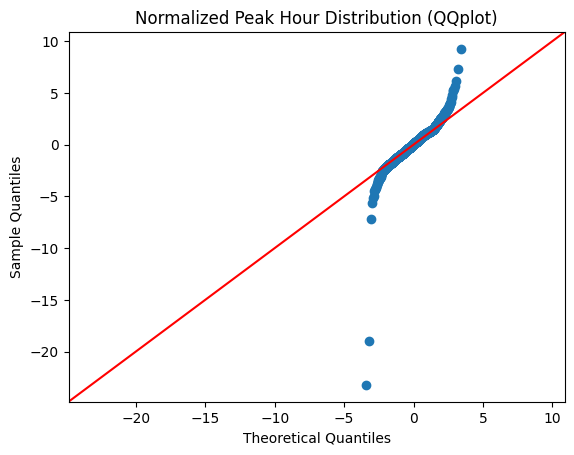

In [71]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_processed_df["normalized_peak_hour"], line="45")
plt.title("Normalized Peak Hour Distribution (QQplot)");

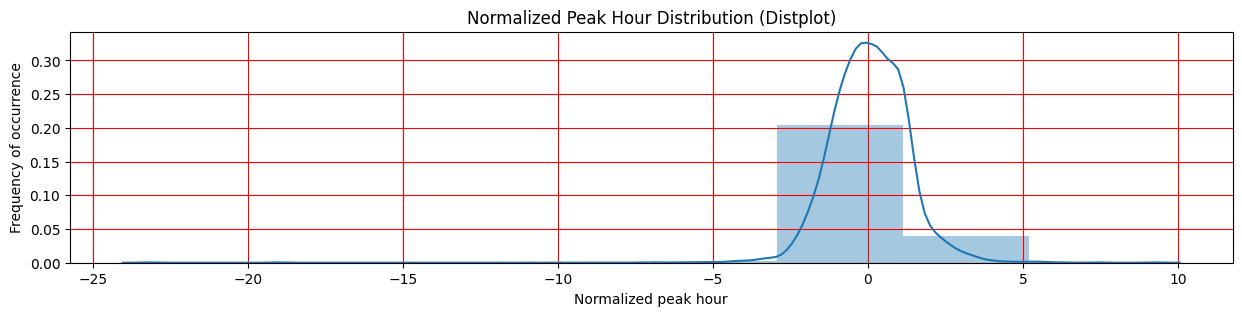

In [72]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_processed_df["normalized_peak_hour"], bins=8, hist=True)
plt.xlabel("Normalized peak hour")
plt.ylabel("Frequency of occurrence")
plt.title("Normalized Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

The target distribution is not normal, but is close to normal.

_________________________________________________________________________________________________________________________________________________________

* Normalized target trend:

In [73]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"]["2012-08":].copy().dropna().to_frame()

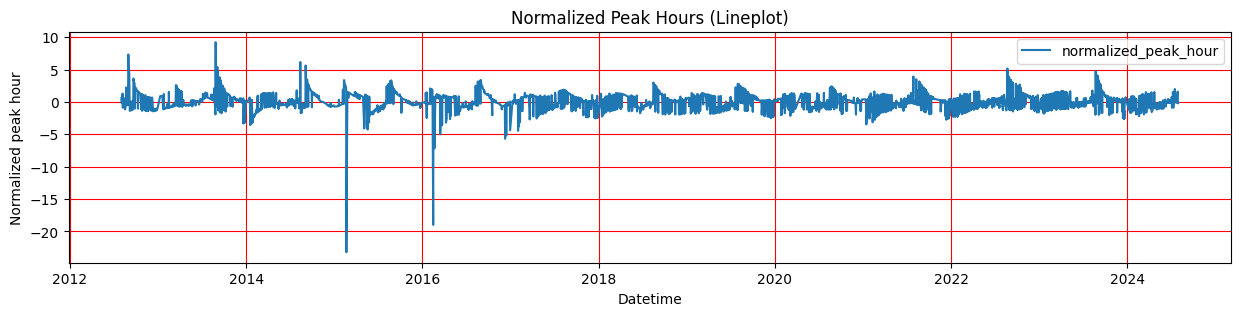

In [74]:
plt.figure(figsize=(15, 3))
sns.lineplot(analyt_processed_df)
plt.xlabel("Datetime")
plt.ylabel("Normalized peak hour")
plt.title("Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does the normalized target has a trend?

In [75]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_processed_df, "normalized_peak_hour", "mean",
                                  get_average_months_length(analyt_processed_df, 2013,
                                                            2023) * 6)).trend + ".")

Answer: decreasing.


Visualise our suggest:

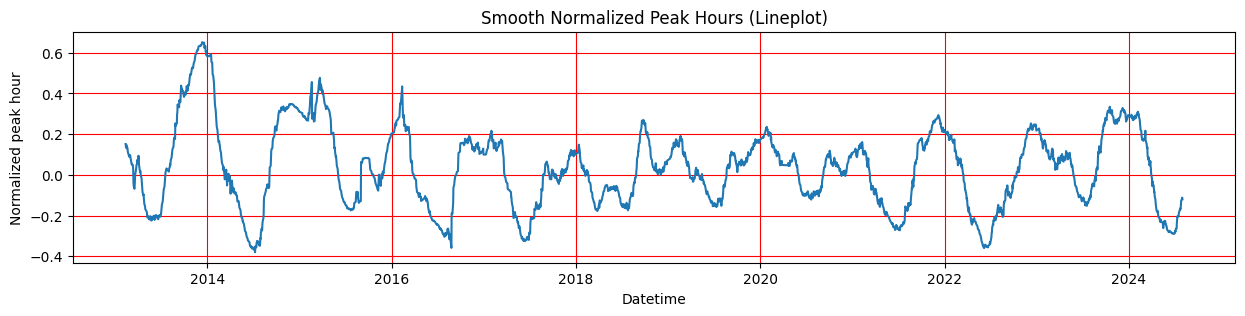

In [76]:
plt.figure(figsize=(15, 3))
sns.lineplot(create_rolling_window_feature(analyt_processed_df, "normalized_peak_hour", "mean",
                                           get_average_months_length(analyt_processed_df, 2013, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [77]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                                 "normalized_peak_hour", "mean",
                                                                                 get_average_months_length(
                                                                                     analyt_processed_df,
                                                                                     2013, 2023) * 6)

analyt_processed_df.dropna(inplace=True)

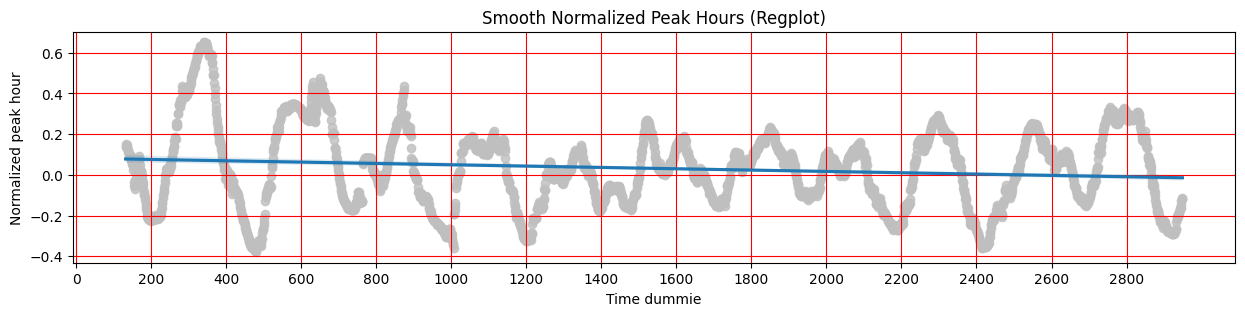

In [78]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 3000, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

The normalized target has a trend.

_________________________________________________________________________________________________________________________________________________________

* The normalized target trend model:

The normalized target has a decreasing trend.

Let's cut a data from beginning, because we have leap at the first time.

This leap is exists because in 2014 year was a political problems which effect on economic and electro consumption.

Let's watch trend plots with difference windows size:

In [79]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [80]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["quarter_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                              "normalized_peak_hour", "mean",
                                                                              get_average_months_length(
                                                                                  analyt_processed_df, 2015,
                                                                                  2023) * 3)

analyt_processed_df.dropna(inplace=True)

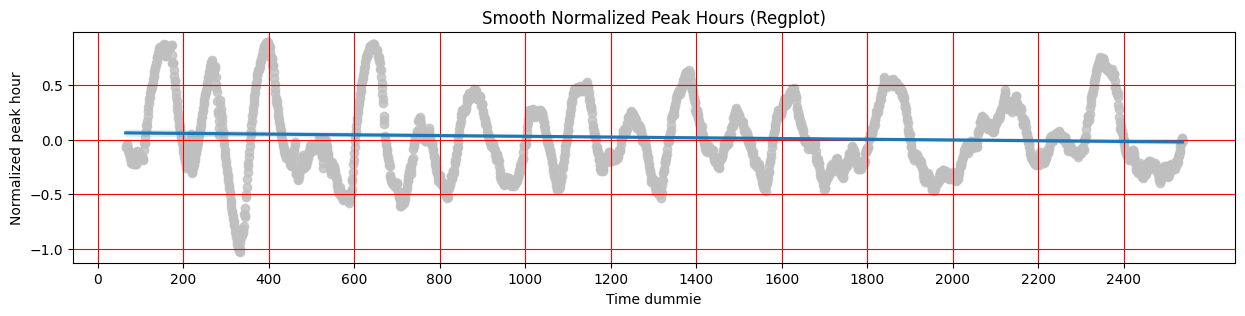

In [81]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="quarter_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [82]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [83]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                                 "normalized_peak_hour", "mean",
                                                                                 get_average_months_length(
                                                                                     analyt_processed_df,
                                                                                     2015, 2023) * 6)

analyt_processed_df.dropna(inplace=True)

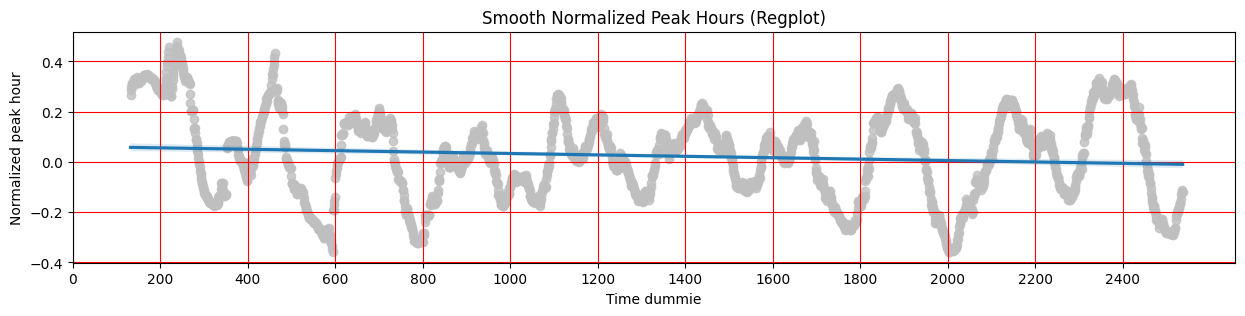

In [84]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [85]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [86]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["annual_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                             "normalized_peak_hour", "mean",
                                                                             get_average_months_length(
                                                                                 analyt_processed_df, 2015,
                                                                                 2023) * 12)

analyt_processed_df.dropna(inplace=True)

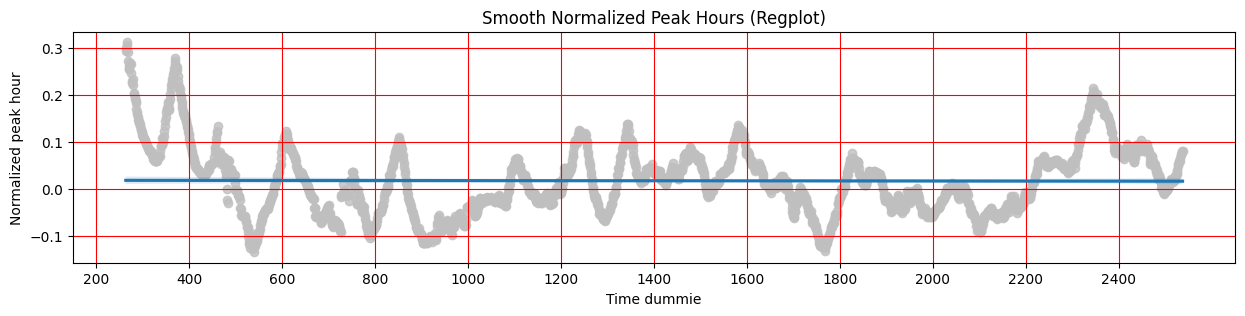

In [87]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="annual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(200, 2500, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

Definitely, we have the linear trend.

At first, delete target data before `2014-04`:

In [88]:
featured_processed_df = featured_processed_df["2014-04":]

Let's create a trend model:

In [89]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().dropna().to_frame()

In [90]:
y = analyt_processed_df["normalized_peak_hour"]

In [91]:
y.head(2)

days
2014-04-01   -0.785835
2014-04-02   -0.760282
Name: normalized_peak_hour, dtype: float64

In [92]:
y.tail(2)

days
2024-07-30   -0.153175
2024-07-31   -0.173530
Name: normalized_peak_hour, dtype: float64

In [93]:
dp = DeterministicProcess(index=y.index, order=1)
x = dp.in_sample()

In [94]:
x.head(2)

,trend
days,
2014-04-01,1.0
2014-04-02,2.0


In [95]:
x.tail(2)

,trend
days,
2024-07-30,2536.0
2024-07-31,2537.0


In [96]:
trend_model = LinearRegression()

In [97]:
trend_model.fit(x, y)

LinearRegression()

We will make prediction to subtract trend from trend (detrending):

In [98]:
y_pred = pd.Series(trend_model.predict(x), index=x.index)

Let's detrending our time series:

In [99]:
featured_processed_df["normalized_peak_hour"] = featured_processed_df["normalized_peak_hour"] - y_pred

And check up updated normalized target:

In [100]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().to_frame()

In [101]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                                 "normalized_peak_hour", "mean",
                                                                                 get_average_months_length(
                                                                                     analyt_processed_df,
                                                                                     2015, 2023) * 6)

analyt_processed_df.dropna(inplace=True)

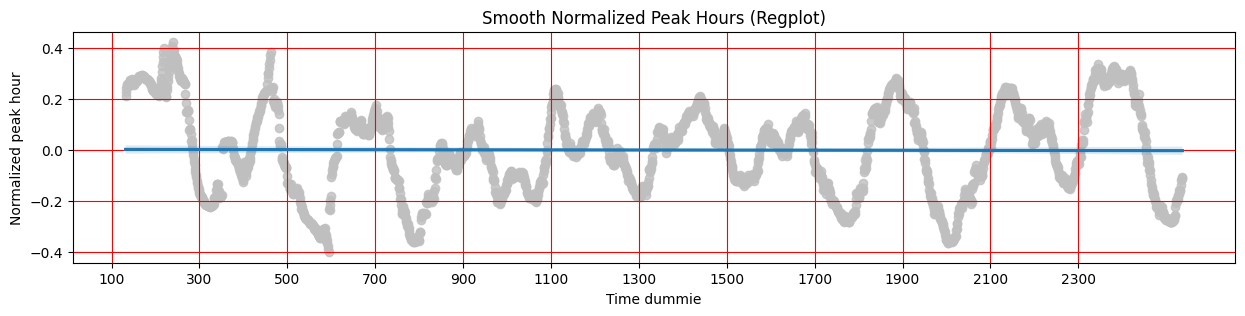

In [102]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(100, 2350, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

Detrending works.

Let's save our trend model:

In [103]:
model_name = "trend_model.sav"
model_path = "../../../models/Пермский край/"

In [104]:
dump(trend_model, open(model_path + model_name, "wb"))

So let's check up the updated target data:

In [105]:
featured_processed_df["normalized_peak_hour"].to_frame().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2537 entries, 2014-04-01 to 2024-07-31
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   normalized_peak_hour  2537 non-null   float64
dtypes: float64(1)
memory usage: 104.2 KB


In [106]:
featured_processed_df["normalized_peak_hour"].to_frame().describe()

,normalized_peak_hour
count,2.537000e+03
mean,9.802521e-18
std,1.315083e+00
min,-2.326946e+01
25%,-7.267608e-01
50%,3.614282e-03
75%,8.455165e-01
max,6.130641e+00


Most of the data is biased in the negative direction.

________________________________________________________________________________________________________________________________________________________

* Detrended normalized target distribution:

In [107]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().to_frame()

Does the detrended normalized target has a normal distribution?

In [108]:
print("Answer:", str(shapiro(analyt_processed_df["normalized_peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

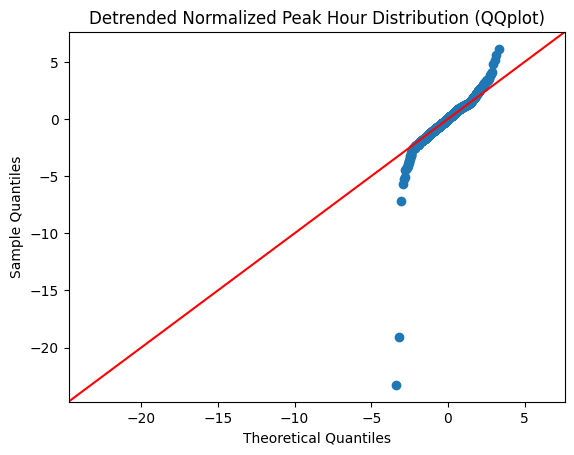

In [109]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_processed_df["normalized_peak_hour"], line="45")
plt.title("Detrended Normalized Peak Hour Distribution (QQplot)");

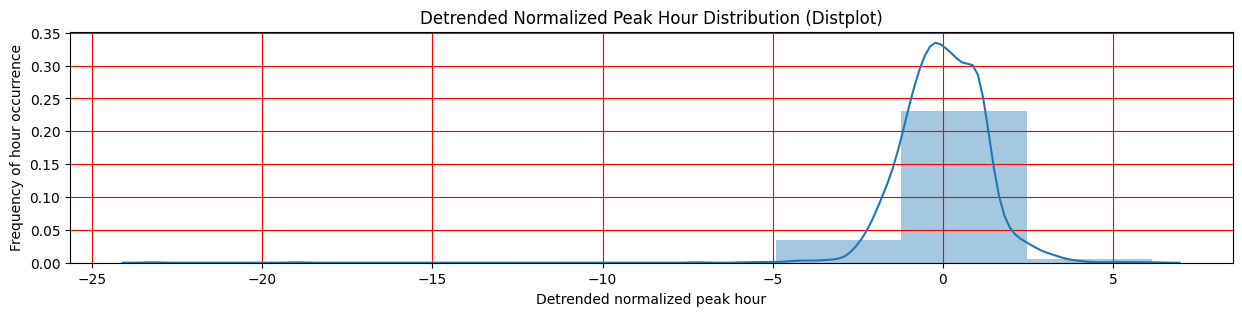

In [110]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_processed_df["normalized_peak_hour"], bins=8, hist=True)
plt.xlabel("Detrended normalized peak hour")
plt.ylabel("Frequency of hour occurrence")
plt.title("Detrended Normalized Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

The distribution is still not normal.

________________________________________________________________________________________________________________________________________________________

* The detrended normalized target trend:

In [111]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().to_frame()

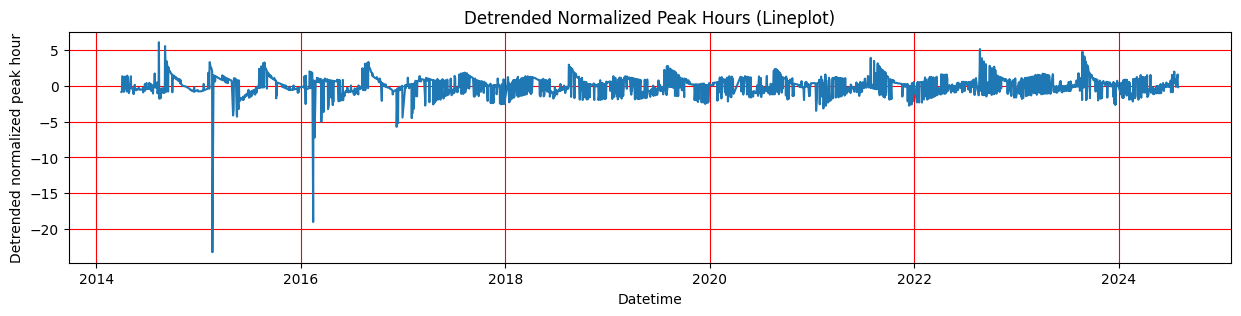

In [112]:
plt.figure(figsize=(15, 3))
figure = sns.lineplot(analyt_processed_df["normalized_peak_hour"])
plt.xlabel("Datetime")
plt.ylabel("Detrended normalized peak hour")
plt.title("Detrended Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does target has a trend?

In [113]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_processed_df, "normalized_peak_hour", "mean",
                                  get_average_months_length(analyt_processed_df, 2015,
                                                            2023) * 6)).trend + ".")

Answer: no trend.


Visualise our suggest:

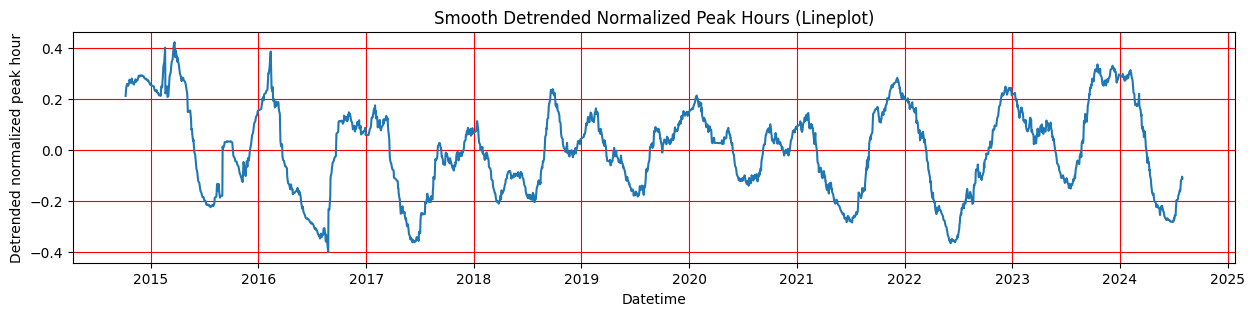

In [114]:
plt.figure(figsize=(15, 3))
sns.lineplot(create_rolling_window_feature(analyt_processed_df, "normalized_peak_hour", "mean",
                                           get_average_months_length(analyt_processed_df, 2015, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [115]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().to_frame()

In [116]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                                 "normalized_peak_hour", "mean",
                                                                                 get_average_months_length(
                                                                                     analyt_processed_df,
                                                                                     2015, 2023) * 6)

analyt_processed_df.dropna(inplace=True)

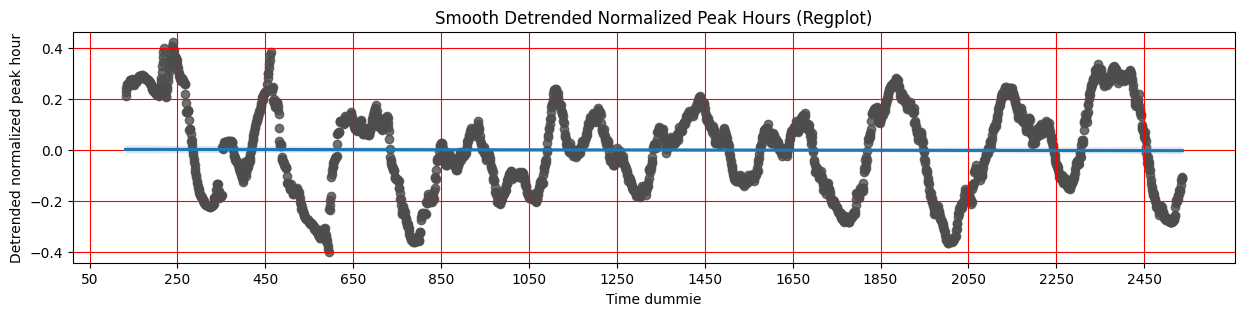

In [117]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(50, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [118]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().to_frame()

In [119]:
analyt_processed_df["time_dummie"] = create_time_dummie_feature(analyt_processed_df)
analyt_processed_df["annual_rolling_window"] = create_rolling_window_feature(analyt_processed_df,
                                                                             "normalized_peak_hour", "mean",
                                                                             get_average_months_length(
                                                                                 analyt_processed_df, 2015,
                                                                                 2023) * 12)

analyt_processed_df.dropna(inplace=True)

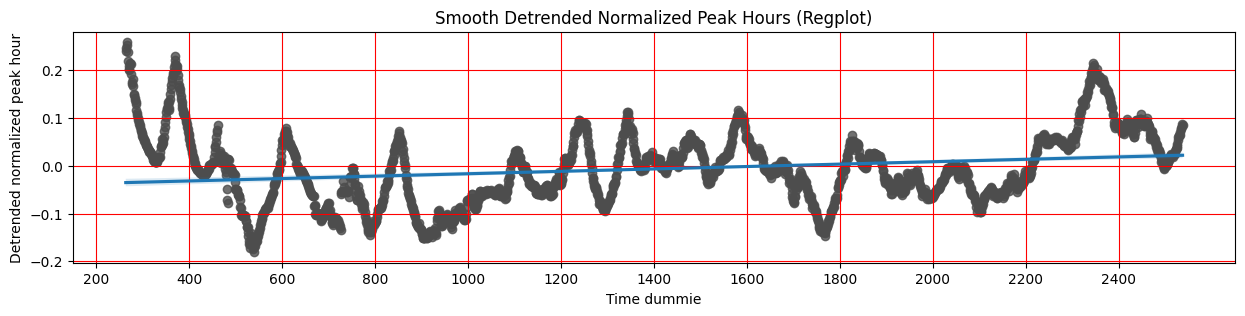

In [120]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="annual_rolling_window", data=analyt_processed_df,
                     scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(200, 2500, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

We have a very little trend.

It will be better to ignore it.

_________________________________________________________________________________________________________________________________________________________

* The detrended normalized target periods:

In [121]:
zxc_index = featured_processed_df["normalized_peak_hour"]
freq = 245

In [122]:
time = np.arange(len(zxc_index), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}

for i in [1, 2, 5]:
    features.update({
        f"sin_{freq}_{i}": np.sin(i * k),
        f"cos_{freq}_{i}": np.cos(i * k),
    })

    zxc = pd.DataFrame(features, index=zxc_index)

In [123]:
# plot_periodogram(featured_processed_df["peak_hour"]["2015": ])

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

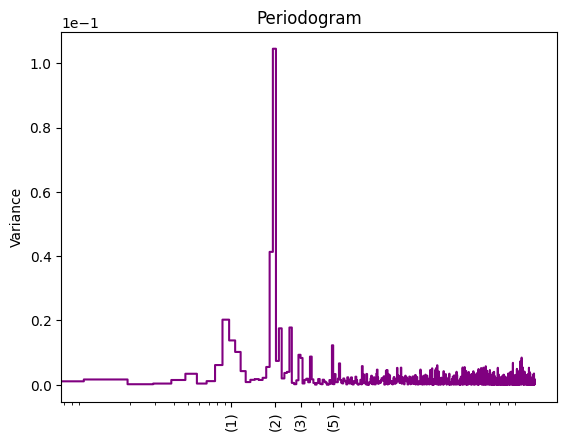

In [124]:
plot_periodogram(featured_processed_df["normalized_peak_hour"])

In [125]:
sm = 0
cnt = 0

for year in range(2015, 2023):
    sm += analyt_processed_df[analyt_processed_df.index.year == year].shape[0]
    cnt += 1

year_days_count = sm / cnt

In [126]:
# X = analyt_processed_df["normalized_peak_hour"].copy().to_frame()
# X["day"] = X.index.dayofweek + 1
# X["week"] = X.index.isocalendar().week
# X["dayofyear"] = X.index.dayofyear
# X["year"] = X.index.year

In [127]:
# seasonal_plot(X["2019-04": "2020-04"], y="normalized_peak_hour", period="week", freq="day")

паттерна нет

In [128]:
# seasonal_plot(X, y="normalized_peak_hour", period="year", freq="dayofyear");

есть паттерн годовой

Год, пол года, квартал, 5 месяцев

Недельной нет.

In [129]:
days = np.arange(len(featured_processed_df["normalized_peak_hour"])) + 1

In [130]:
# # res1 = create_fourier_features(days, year_days_count)
# # res2 = create_fourier_features(days, (year_days_count + 1) // 2)
# # res3 = create_fourier_features(days, (year_days_count + 1) // 5)

# year_sin = pd.Series(np.sin(2 * np.pi * days / 247 * 2.02))
# year_cos = pd.Series(np.cos(2 * np.pi * days / 247 * 2.02))

# res = pd.concat({"year_cos": year_cos, "year_sin": year_sin}, axis=1)

# # res = pd.concat([res1, res2, res3], axis=1)

In [131]:
season_model = LinearRegression(fit_intercept=False)
_ = season_model.fit(zxc, featured_processed_df["normalized_peak_hour"])

In [132]:
y_pred = pd.Series(season_model.predict(zxc), index=featured_processed_df["normalized_peak_hour"].index)

In [133]:
y_pred

days
2014-04-01    0.235281
2014-04-02    0.246197
2014-04-03    0.254720
2014-04-04    0.260599
2014-04-07    0.263614
                ...   
2024-07-25   -0.059175
2024-07-26   -0.027060
2024-07-29    0.007730
2024-07-30    0.045063
2024-07-31    0.084796
Length: 2537, dtype: float32

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

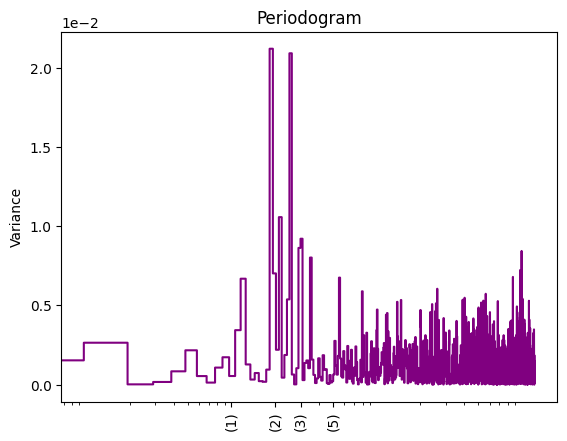

In [134]:
plot_periodogram(featured_processed_df["normalized_peak_hour"] - y_pred)

In [135]:
featured_processed_df["normalized_peak_hour"] = featured_processed_df["normalized_peak_hour"] - y_pred

In [136]:
model_name = "season_model.sav"
model_path = "../../../models/Пермский край/"
dump(trend_model, open(model_path + model_name, "wb"))

_________________________________________________________________________________________________________________________________________________________

* Check normalize target correlation:

In [137]:
analyt_processed_df = featured_processed_df["normalized_peak_hour"].copy().dropna().to_frame()

In [138]:
# print("Does normalized data a autocorrelation?")
# print("Answer:", f'{max(sm.tsa.acf(analyt_processed_df["normalized_peak_hour"])[1:]) > 0.4}.')
# print("Visualise our suggest.")

<Figure size 2000x400 with 0 Axes>

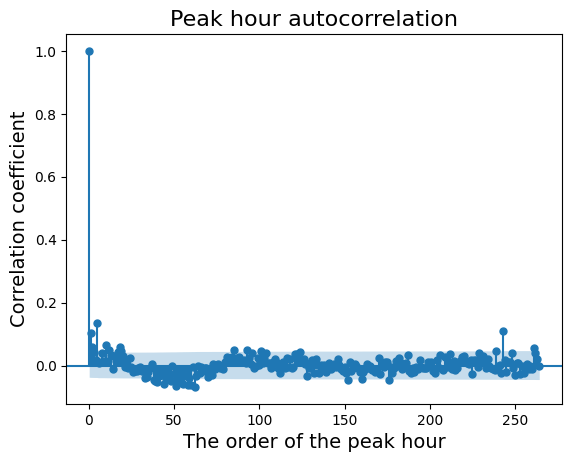

In [139]:
plt.figure(figsize=(20, 4))
autocorr_plot(analyt_processed_df["normalized_peak_hour"],
              lags=get_average_months_length(analyt_processed_df, 2015, 2023) * 12)
plt.axis("tight")
plt.ylabel("Correlation coefficient", fontsize=14)
plt.xlabel("The order of the peak hour", fontsize=14)
plt.title("Peak hour autocorrelation", fontsize=16)
plt.show();

In [140]:
print("Let's see a separated cases:")

Let's see a separated cases:


In [141]:
# analyt_processed_df["day_lag"] = create_lag_feature(analyt_processed_df, "normalized_peak_hour", 1)
# analyt_processed_df["week_lag"] = create_lag_feature(analyt_processed_df, "normalized_peak_hour", 5)
# analyt_processed_df["two_weeks_lag"] = create_lag_feature(analyt_processed_df, "normalized_peak_hour", 10)

In [142]:
# plt.figure(figsize=(20, 4))
# fig, ax = plt.subplots()
# ax = sns.regplot(x="day_lag", y="normalized_peak_hour", data=analyt_processed_df.dropna(), ci=None,
#                  scatter_kws=dict(color="0.25"))
# ax.set_aspect("equal")
# plt.ylabel("Current normalized peak hour", fontsize=14)
# plt.xlabel("Day lag normalized peak hour", fontsize=14)
# ax.set_title("Lag plot of normalized peak hour")

In [143]:
# plt.figure(figsize=(20, 4))
# autocorr_plot(analyt_processed_df["normalized_peak_hour"], lags=get_average_months_length(analyt_processed_df, 2012, 2023) * 30)
# plt.axis("tight")
# plt.ylabel("Correlation coefficient", fontsize=14)
# plt.xlabel("The order of the peak hour", fontsize=14)
# plt.title("Autocorrelation", fontsize=16)
# plt.show();

In [144]:
# print("There is a strong changing correlation.")

In [145]:
featured_processed_df["lag_1"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 1)
featured_processed_df["lag_2"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 2)
featured_processed_df["lag_5"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 5)
featured_processed_df["lag_7"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 7)
featured_processed_df["lag_10"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 10)
featured_processed_df["lag_28"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 28)
featured_processed_df["lag_59"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 59)
featured_processed_df["lag_245"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 245)
featured_processed_df["lag_247"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 247)

________________________________________________________________________________________________________________________________________________________

#### WORKING WITH FEATURES

* TIME DUMMIE FEATURE

In [146]:
# featured_processed_df["time_dummie"] = create_time_dummie_feature(featured_processed_df)

In [147]:
# featured_processed_df.head(2)

In [148]:
# featured_processed_df.tail(2)

* DATETIME FEATURE

In [149]:
# featured_processed_df = pd.concat([featured_processed_df, create_dayofweek_features(featured_processed_df)[
#     ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday"]]],
#                         axis=1)

In [150]:
# featured_processed_df.head(2)

In [151]:
featured_processed_df["day_of_month"] = featured_processed_df.index.day
featured_processed_df["day_of_year"] = featured_processed_df.index.dayofyear
featured_processed_df["week_of_year"] = featured_processed_df.index.isocalendar().week
featured_processed_df["month"] = featured_processed_df.index.month
featured_processed_df["quarter"] = featured_processed_df.index.quarter
featured_processed_df["year"] = featured_processed_df.index.year

In [152]:
# featured_processed_df.head(2)

* HOLIDAYS FEATURE

In [153]:
# print("Current dataframe has a holidays?", f"Answer: {sum(create_holiday_feature(processed_df)) > 0}.")

* ROLLING MEAN WINDOW FEATURES

In [154]:
# featured_processed_df["rolling_mean_week"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "mean", 5).shift(
#     1)

In [155]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.title("Mean week")
# plt.grid(color='r', linestyle='-');

In [156]:
# featured_processed_df["rolling_mean_month"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "mean",
#                                                                   get_average_months_length(featured_processed_df, 2012,
#                                                                                             2023)).shift(1)

In [157]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_month")
# plt.title("Mean month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [158]:
# featured_processed_df["rolling_mean_quarter"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 3
# ).shift(1)

In [159]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_quarter")
# plt.title("Mean quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [160]:
# featured_processed_df["rolling_mean_semiannual"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 6
# ).shift(1)

In [161]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_semiannual")
# plt.title("Mean semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [162]:
# featured_processed_df["rolling_mean_annual"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 12
# ).shift(1)

In [163]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_annual")
# plt.title("Mean annual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [164]:
# featured_processed_df["rolling_mean_quinquennial"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 60
# ).shift(1)

In [165]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_quinquennial")
# plt.title("Mean quinquennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [166]:
# featured_processed_df["rolling_mean_decennial"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 120
# ).shift(1)

In [167]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_mean_decennial")
# plt.title("Mean decennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MEDIAN WINDOW FEATURES

In [168]:
# featured_processed_df["rolling_median_week"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "median",
#                                                                    5).shift(1)

In [169]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_median_week")
# plt.title("Median week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [170]:
# featured_processed_df["rolling_median_month"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_processed_df, 2012, 2023)
# ).shift(1)

In [171]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_median_month")
# plt.title("Median month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [172]:
# featured_processed_df["rolling_median_quarter"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 3
# ).shift(1)

In [173]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_median_quarter")
# plt.title("Median quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [174]:
# featured_processed_df["rolling_median_semiannual"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 6
# ).shift(1)

In [175]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_median_semiannual")
# plt.title("Median semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MAX WINDOW FEATURES

In [176]:
# featured_processed_df["rolling_max_week"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "max", 5).shift(1)

In [177]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_max_week")
# plt.title("Max week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [178]:
# featured_processed_df["rolling_max_month"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "max",
#                                                                  get_average_months_length(featured_processed_df, 2012,
#                                                                                            2023)).shift(1)

In [179]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_max_month")
# plt.title("Max month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [180]:
# featured_processed_df["rolling_max_quarter"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "max",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 3
# ).shift(1)

In [181]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_max_quarter")
# plt.title("Max quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MIN WINDOW FEATURES

In [182]:
# featured_processed_df["rolling_min_week"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "min", 5).shift(1)

In [183]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_min_week")
# plt.title("Min week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [184]:
# featured_processed_df["rolling_min_month"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "min",
#                                                                  get_average_months_length(featured_processed_df, 2012,
#                                                                                            2023)).shift(1)

In [185]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_min_month")
# plt.title("Min month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [186]:
# featured_processed_df["rolling_min_quarter"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "min",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 3
# ).shift(1)

In [187]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_min_quarter")
# plt.title("Min quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING STD WINDOW FEATURES

In [188]:
# featured_processed_df["rolling_std_week"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "std", 5).shift(1)

In [189]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_std_week")
# plt.title("Std week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [190]:
# featured_processed_df["rolling_std_month"] = create_rolling_window_feature(featured_processed_df, "normalized_peak_hour", "std",
#                                                                  get_average_months_length(featured_processed_df, 2012,
#                                                                                            2023)).shift(1)

In [191]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_std_month")
# plt.title("Std month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [192]:
# featured_processed_df["rolling_std_quarter"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 3
# ).shift(1)

In [193]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_std_quarter")
# plt.title("Std quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [194]:
# featured_processed_df["rolling_std_semiannual"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 6
# ).shift(1)

In [195]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_std_semiannual")
# plt.title("Std semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [196]:
# featured_processed_df["rolling_std_annual"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 12
# ).shift(1)

In [197]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_std_annual")
# plt.title("Std annual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [198]:
# featured_processed_df["rolling_std_quinquennial"] = create_rolling_window_feature(
#     featured_processed_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_processed_df, 2012, 2023) * 60
# ).shift(1)

In [199]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_processed_df, x=featured_processed_df.index, y="rolling_std_quinquennial")
# plt.title("Std quinquennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

________________________________________________________________________________________________________________________________________________________

#### WORKING WITH LAG FEATURES

In [200]:
# featured_processed_df

In [201]:
# featured_processed_df["day_lag"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 1)
# featured_processed_df["week_lag"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 5)
# featured_processed_df["month_lag"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 25)
# featured_processed_df["quarter_lag"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 75)
# featured_processed_df["half_year_lag"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 120)
# featured_processed_df["year_lag"] = create_lag_feature(featured_processed_df, "normalized_peak_hour", 240)

________________________________________________________________________________________________________________________________________________________

In [202]:
# featured_processed_df

MAKE PREDICTIONS:

In [203]:
# featured_processed_df = featured_processed_df.drop("time_dummie", axis=1)

In [204]:
# featured_processed_df

In [205]:
# std_norm = featured_processed_df["std_norm"]
# mean_norm = featured_processed_df["mean_norm"]

In [206]:
featured_processed_df.columns

Index(['peak_hour', 'std_normalization', 'mean_normalization',
       'normalized_peak_hour', 'time_dummie', 'mean', 'lag_1', 'lag_2',
       'lag_5', 'lag_7', 'lag_10', 'lag_28', 'lag_59', 'lag_245', 'lag_247',
       'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter',
       'year'],
      dtype='object')

In [207]:
featured_processed_df.dropna(inplace=True)

In [208]:
featured_processed_df

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour,time_dummie,mean,lag_1,lag_2,lag_5,lag_7,...,lag_28,lag_59,lag_245,lag_247,day_of_month,day_of_year,week_of_year,month,quarter,year
days,,,,,,,,,,,,,,,,,,,,,
2015-04-03,20,1.597489,17.888889,1.016257,744,1.187616,1.071131,1.131112,1.302450,0.723729,...,-23.219584,0.051218,-1.071912,-1.078078,3,93,14,4,2,2015
2015-04-06,19,1.615180,17.936508,0.347321,745,1.153195,1.016257,1.071131,0.583112,0.679154,...,0.778122,-0.161181,1.097018,-1.063415,6,96,15,4,2,2015
2015-04-07,20,1.616131,17.968254,0.943064,746,1.148079,0.347321,1.016257,1.196271,1.302450,...,1.575739,-0.171148,1.047971,-1.071912,7,97,15,4,2,2015
2015-04-08,20,1.631268,18.015873,0.902271,747,1.143084,0.943064,0.347321,1.131112,0.583112,...,0.723054,-0.183430,1.025463,1.097018,8,98,15,4,2,2015
2015-04-09,19,1.644865,18.063492,0.258578,748,1.110558,0.902271,0.943064,1.071131,1.196271,...,0.707131,-0.188440,1.006832,1.047971,9,99,15,4,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,14,1.970988,12.285714,0.937799,3029,0.436436,0.988685,-0.005655,1.142856,1.089370,...,0.546892,-0.196967,-0.082905,0.310629,25,207,30,7,3,2024
2024-07-26,14,1.980835,12.301587,0.893373,3030,0.463895,0.937799,0.988685,0.592693,2.215890,...,0.209597,0.108954,-0.109247,0.260328,26,208,30,7,3,2024
2024-07-29,15,1.733528,12.206349,1.612727,3031,0.525632,0.893373,0.937799,1.061186,1.142856,...,0.841049,0.139708,-0.104190,-0.082905,29,211,31,7,3,2024


In [209]:
featured_processed_df.to_parquet("../../model_development/feature_data.gzip")

In [210]:
zxc = featured_processed_df.copy()

In [211]:
y = featured_processed_df["normalized_peak_hour"].copy()

In [212]:
featured_processed_df = featured_processed_df.drop(
    columns=["peak_hour", "std_normalization", "mean_normalization", "time_dummie"], axis=1)

In [213]:
featured_processed_df

,normalized_peak_hour,mean,lag_1,lag_2,lag_5,lag_7,lag_10,lag_28,lag_59,lag_245,lag_247,day_of_month,day_of_year,week_of_year,month,quarter,year
days,,,,,,,,,,,,,,,,,
2015-04-03,1.016257,1.187616,1.071131,1.131112,1.302450,0.723729,0.864235,-23.219584,0.051218,-1.071912,-1.078078,3,93,14,4,2,2015
2015-04-06,0.347321,1.153195,1.016257,1.071131,0.583112,0.679154,0.816516,0.778122,-0.161181,1.097018,-1.063415,6,96,15,4,2,2015
2015-04-07,0.943064,1.148079,0.347321,1.016257,1.196271,1.302450,0.769601,1.575739,-0.171148,1.047971,-1.071912,7,97,15,4,2,2015
2015-04-08,0.902271,1.143084,0.943064,0.347321,1.131112,0.583112,0.723729,0.723054,-0.183430,1.025463,1.097018,8,98,15,4,2,2015
2015-04-09,0.258578,1.110558,0.902271,0.943064,1.071131,1.196271,0.679154,0.707131,-0.188440,1.006832,1.047971,9,99,15,4,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,0.937799,0.436436,0.988685,-0.005655,1.142856,1.089370,-0.641693,0.546892,-0.196967,-0.082905,0.310629,25,207,30,7,3,2024
2024-07-26,0.893373,0.463895,0.937799,0.988685,0.592693,2.215890,0.246083,0.209597,0.108954,-0.109247,0.260328,26,208,30,7,3,2024
2024-07-29,1.612727,0.525632,0.893373,0.937799,1.061186,1.142856,1.129253,0.841049,0.139708,-0.104190,-0.082905,29,211,31,7,3,2024


In [214]:
# true_val = featured_processed_df["peak_hour"]

In [215]:
# featured_processed_df.drop(columns=["peak_hour"], axis=1, inplace=True)

In [216]:
# featured_processed_df

In [217]:
# featured_processed_df["time_dummie"] = create_time_dummie_feature(featured_processed_df)

In [218]:
featured_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2015-04-03 to 2024-07-31
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   normalized_peak_hour  2290 non-null   float64
 1   mean                  2290 non-null   float64
 2   lag_1                 2290 non-null   float64
 3   lag_2                 2290 non-null   float64
 4   lag_5                 2290 non-null   float64
 5   lag_7                 2290 non-null   float64
 6   lag_10                2290 non-null   float64
 7   lag_28                2290 non-null   float64
 8   lag_59                2290 non-null   float64
 9   lag_245               2290 non-null   float64
 10  lag_247               2290 non-null   float64
 11  day_of_month          2290 non-null   int32  
 12  day_of_year           2290 non-null   int32  
 13  week_of_year          2290 non-null   UInt32 
 14  month                 2290 non-null   int32  
 15  qua

In [219]:
featured_processed_df.drop(columns=["normalized_peak_hour"], inplace=True)

In [220]:
featured_processed_df.drop(columns=["mean"], inplace=True)

In [221]:
train_x = featured_processed_df[: 1900]
test_x = featured_processed_df[1900:]

In [222]:
train_y = y[: 1900]
test_y = y[1900:]

In [223]:
from xgboost import XGBRegressor

In [224]:
model = XGBRegressor(n_estimators=100, max_depth=3)

In [225]:
# help(model)

In [226]:
# help(model.fit)

In [227]:
model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], eval_metric="mae", verbose=10,
          early_stopping_rounds=6)

[0]	validation_0-mae:0.84345	validation_1-mae:0.84477
[9]	validation_0-mae:0.76987	validation_1-mae:0.83711


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [228]:
data = pd.concat([train_x, test_x], axis=0)

In [229]:
target = pd.concat([train_y, test_y], axis=0)

In [230]:
# model.fit(data, target)

In [231]:
import pickle

In [232]:
file_name = "xgb_reg.pkl"

pickle.dump(model, open(model_path + file_name, "wb"))

_________________________________________________________________________________________________________________________________________________________

In [233]:
zxc_index = zxc
freq = 245

time = np.arange(len(zxc), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}

for i in [1, 2, 5]:
    features.update({
        f"sin_{freq}_{i}": np.sin(i * k),
        f"cos_{freq}_{i}": np.cos(i * k),
    })

    sincos = pd.DataFrame(features, index=zxc_index)

In [234]:
sincos.index = zxc.index

In [235]:
zxc = pd.concat([zxc, sincos], axis=1)

In [236]:
dp = DeterministicProcess(index=zxc.index, order=1)

In [237]:
zxc["trend"] = dp.in_sample()

In [238]:
zxc["trend"] += 2537 - 2290

In [239]:
pred = model.predict(zxc[model.feature_names_in_])

In [240]:
pred = pred + season_model.predict(zxc[season_model.feature_names_in_])

In [241]:
pred = pred + trend_model.predict(zxc[trend_model.feature_names_in_])

In [242]:
res = pred * zxc["std_normalization"] + zxc["mean_normalization"]

In [243]:
import datetime

In [244]:
model.feature_names_in_

array(['lag_1', 'lag_2', 'lag_5', 'lag_7', 'lag_10', 'lag_28', 'lag_59',
       'lag_245', 'lag_247', 'day_of_month', 'day_of_year',
       'week_of_year', 'month', 'quarter', 'year'], dtype='<U12')

In [245]:
dd = 1
lst = [1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30]

freq = 245

In [246]:
for _ in range(31):
    new_processed_df = processed_df.copy()

    if (new_processed_df.index[-1] + datetime.timedelta(days=dd)).day not in lst:
        dd += 1
        continue
    else:
        day_node = new_processed_df.iloc[-1]
        day_node.name += datetime.timedelta(days=dd)
        day_node = pd.DataFrame({"peak_hour": np.nan}, index=[day_node.name])
        new_processed_df = pd.concat([new_processed_df, day_node], axis=0)
        # С НОВЫМ ДНЁМ processed_df

        new_processed_df["day_of_month"] = new_processed_df.index.day

        new_processed_df = normalization(new_processed_df, "peak_hour")
        # НСРМАЛИЗОВАННЫЙ processed_df

        new_processed_df = new_processed_df["2014-04":]

        dp = DeterministicProcess(index=new_processed_df.index, order=1)
        x = dp.in_sample()
        new_processed_df["trend"] = x

        y_pred = pd.Series(trend_model.predict(x), index=new_processed_df.index)
        new_processed_df["normalized_peak_hour"] = new_processed_df["normalized_peak_hour"] - y_pred
        # Detrended

        indx = new_processed_df["normalized_peak_hour"]
        freq = 245

        time = np.arange(len(indx), dtype=np.float32)
        k = 2 * np.pi * (1 / freq) * time
        features = {}

        for i in [1, 2, 5]:
            features.update({
                f"sin_{freq}_{i}": np.sin(i * k),
                f"cos_{freq}_{i}": np.cos(i * k),
            })

        fourier_features = pd.DataFrame(features, index=indx)

        y_pred = pd.Series(season_model.predict(fourier_features), index=new_processed_df["normalized_peak_hour"].index)
        new_processed_df["normalized_peak_hour"] = new_processed_df["normalized_peak_hour"] - y_pred

        new_processed_df["lag_1"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 1)
        new_processed_df["lag_2"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 2)
        new_processed_df["lag_5"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 5)
        new_processed_df["lag_7"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 7)
        new_processed_df["lag_10"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 10)
        new_processed_df["lag_28"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 28)
        new_processed_df["lag_59"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 59)
        new_processed_df["lag_245"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 245)
        new_processed_df["lag_247"] = create_lag_feature(new_processed_df, "normalized_peak_hour", 247)

        new_processed_df["day_of_month"] = new_processed_df.index.day
        new_processed_df["day_of_year"] = new_processed_df.index.dayofyear
        new_processed_df["week_of_year"] = new_processed_df.index.isocalendar().week
        new_processed_df["month"] = new_processed_df.index.month
        new_processed_df["quarter"] = new_processed_df.index.quarter
        new_processed_df["year"] = new_processed_df.index.year

        new_processed_df["normalized_peak_hour"] = pd.Series(model.predict(new_processed_df[model.feature_names_in_]),
                                                             index=new_processed_df.index)

        y_pred = pd.Series(season_model.predict(fourier_features), index=new_processed_df["normalized_peak_hour"].index)
        new_processed_df["normalized_peak_hour"] = new_processed_df["normalized_peak_hour"] + y_pred

        y_pred = pd.Series(trend_model.predict(x), index=new_processed_df.index)
        new_processed_df["normalized_peak_hour"] = new_processed_df["normalized_peak_hour"] + y_pred

        new_processed_df["peak_hour"] = new_processed_df["normalized_peak_hour"] * new_processed_df[
            "std_normalization"] + new_processed_df[
                                            "mean_normalization"]

        day_node = processed_df.iloc[-1]
        day_node.name += datetime.timedelta(days=dd)
        day_node = pd.DataFrame({"peak_hour": np.nan}, index=[day_node.name])
        processed_df = pd.concat([processed_df, day_node], axis=0)
        processed_df["peak_hour"][-1] = round(new_processed_df["peak_hour"][-1])
        dd = 1

In [247]:
zxc = pd.concat([new_processed_df["2024-08":], real_data], axis=1, names=["predict", "real"])

In [248]:
zxc.columns = ["predict", "real"]

In [249]:
for i in zxc["real"]:
    print(int(i))

13
12
13
12
10
12
13
16
20
12
20
12
10
12
20
13
12
20
20
12
19
12


In [250]:
for i in zxc["predict"]:
    print(int(i))

13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
